# Importing Libraries and getting url

In [237]:
!pip install graphviz
!pip install matplotlib_venn
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve
from sklearn.metrics import auc, classification_report, confusion_matrix
from sklearn import tree, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.externals.six import StringIO 
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from IPython.display import Image  
from Funnky import print_metrics, find_best_k, roc, plot_feature_importances
from sklearn.tree import export_graphviz
from matplotlib_venn import venn2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
url='http://strainapi.evanbusse.com/80Bxz5h/strains/search/all'
response=requests.get(url)
dat=response.json()

## Creating Effects & Types DataFrame

In [240]:
names=list(dat.keys())
positive,negative,medical,posi,neg,med,eff,tye=[],[],[],[],[],[],[],[]
for n in names:
    tye.append(dat[n]['race'])
    eff.append(dat[n]['effects']['positive']+dat[n]['effects']['negative']+dat[n]['effects']['medical'])
    positive.append(dat[n]['effects']['positive'])
    posi.append(len(dat[n]['effects']['positive']))
    negative.append(dat[n]['effects']['negative'])
    neg.append(len(dat[n]['effects']['negative']))
    medical.append(dat[n]['effects']['medical'])
    med.append(len(dat[n]['effects']['medical']))
dic={'name':names,'type':tye,'effects':eff}
df=pd.DataFrame(dic)
df.head()

,name,type,effects
0,Afpak,hybrid,"[Relaxed, Hungry, Happy, Sleepy, Dizzy, Depres..."
1,African,sativa,"[Euphoric, Happy, Creative, Energetic, Talkati..."
2,Afternoon Delight,hybrid,"[Relaxed, Hungry, Euphoric, Uplifted, Tingly, ..."
3,Afwreck,hybrid,"[Relaxed, Happy, Creative, Uplifted, Sleepy, D..."
4,Agent Orange,hybrid,"[Relaxed, Euphoric, Happy, Energetic, Uplifted..."


In [241]:
negit=[]
for med in negative:
    for n in med:
        if n not in negit:
            negit.append(n)
negit

['Dizzy', 'Dry Mouth', 'Paranoid', 'Dry Eyes', 'Anxious']

## Cleaning up dataframe, creating dummy columns for all effects

In [242]:
effects=[]
pos=list(eff)
for p in pos:
    for i in p:
        if i not in effects:
            effects.append(i)
for i in effects:
    title=str(i)
    title=[]
    for x in df['effects']:
        if i in x:
            title.append(1)
        else:
            title.append(0)
    df[i]=title

In [243]:
effects

['Relaxed',
 'Hungry',
 'Happy',
 'Sleepy',
 'Dizzy',
 'Depression',
 'Insomnia',
 'Pain',
 'Stress',
 'Lack of Appetite',
 'Euphoric',
 'Creative',
 'Energetic',
 'Talkative',
 'Dry Mouth',
 'Nausea',
 'Headache',
 'Uplifted',
 'Tingly',
 'Paranoid',
 'Cramps',
 'Dry Eyes',
 'Fatigue',
 'Headaches',
 'Muscle Spasms',
 'Focused',
 'Eye Pressure',
 'Anxious',
 'Giggly',
 'Aroused',
 'Inflammation',
 'Spasticity',
 'Seizures']

## Get dummies for type (indica=0,sativa=1,hybrid=2)
### Engineer features for positive effect score, negative effect score, and medical effect score

In [244]:
df.drop(columns='effects',inplace=True)
df.type=df.type.map({'indica':0,'sativa':1,'hybrid':2})
lowers=[]
for n in df['name']:
    lowers.append(n.lower())
df['name']=lowers
df['positive']=posi
df['negative']=neg
df['medical']=med
df.head(2)

ValueError: Length of values does not match length of index

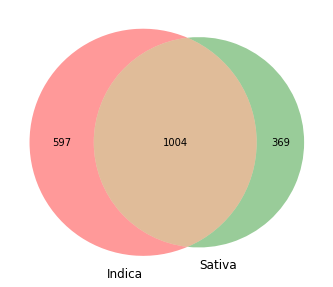

In [246]:
plt.figure(figsize=(10,5))
venn2(subsets=(len(df[df['type']==0]),len(df[df['type']==1]),len(df[df['type']==2])),set_labels=('Indica','Sativa'))
plt.savefig('VennDiagram_Indica_Sativa')



# Getting THC content data

In [111]:
namelist=[]
# typelist=[]
thclist=[]
for i in range(1,62):
    response=requests.get('https://www.wikileaf.com/strains/?page={}'.format(i))
    soup=BeautifulSoup(response.content,'html.parser')
    names=soup.findAll('h5',{'class':'name disp-title'})
#     types=soup.findAll('p',{'class':'tag'})
    thcs=soup.findAll('p',{'class':'desc'})
    for n,x in zip(names,thcs):
        namelist.append(n.text.lower())
#         typelist.append(t.text.lower())
        thclist.append(int(x.text[3:6].strip('%')))
effects.append('thc')

In [112]:
moreinfo={'name':namelist,'thc':thclist}
df3=pd.DataFrame(moreinfo)
fulldf=pd.merge(df,df3,on='name')
fulldf.sort_values('thc',inplace=True)
fulldf.reset_index(inplace=True)
fulldf.drop(columns='index',inplace=True)
fulldf.head()

,name,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,madagascar,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,5,3,5,0
1,four cups,2,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,5,1,5,0
2,eastern european,0,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,3,1,5,0
3,deep cheese,2,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,5,3,4,0
4,north indian,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,5,2,4,0


## PCA ??? CONFUSED

In [113]:
# pca = PCA()
# features=fulldf.drop(columns='name')
# transformed = pca.fit_transform(features)

In [114]:
# plt.scatter(transformed[:,0], transformed[:,1]);
# pca.components_

In [115]:
# pca.mean_

## Looking for class imbalance

Probability of Indica: 0.2823871906841339
Probability of Sativa: 0.19796215429403202
Probability of Hybrid: 0.519650655021834


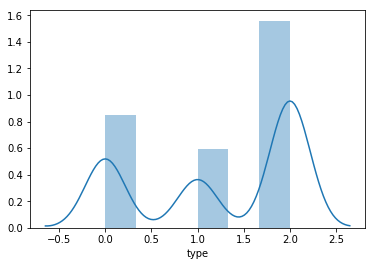

In [116]:
indicadf=fulldf[fulldf['type']==0]
sativadf=fulldf[fulldf['type']==1]
hybriddf=fulldf[fulldf['type']==2]

sns.distplot(fulldf['type'])
prind=len(indicadf)/len(fulldf)
prsat=len(sativadf)/len(fulldf)
prhyb=len(hybriddf)/len(fulldf)
print('Probability of Indica: {}'.format(prind))
print('Probability of Sativa: {}'.format(prsat))
print('Probability of Hybrid: {}'.format(prhyb))

### Classes are balanced fine, no one class pulls more than even 60%.

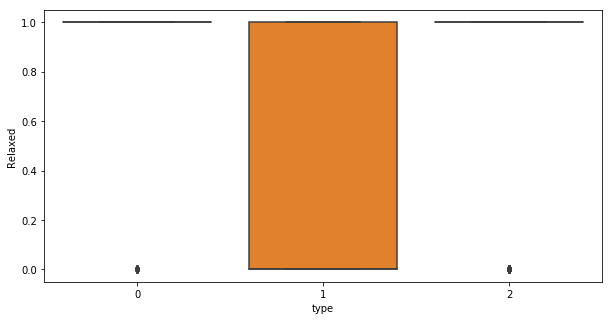

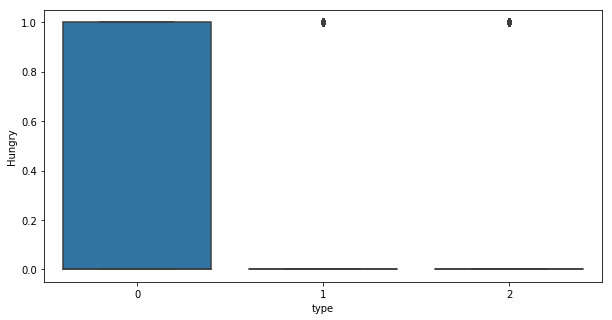

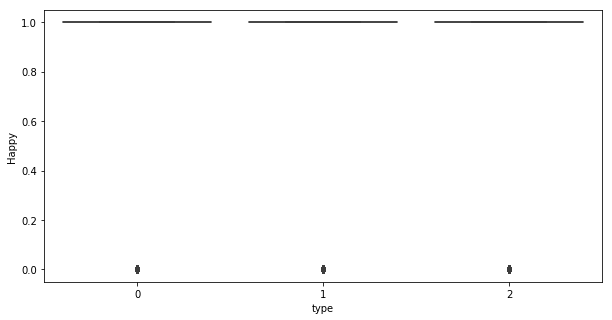

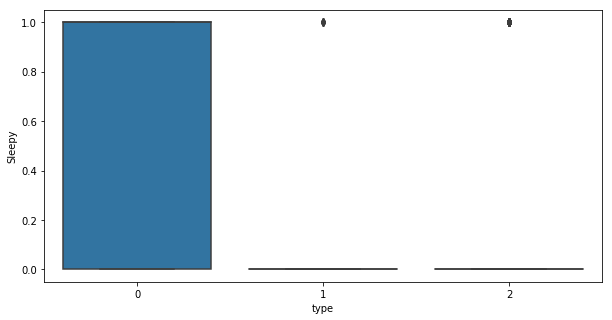

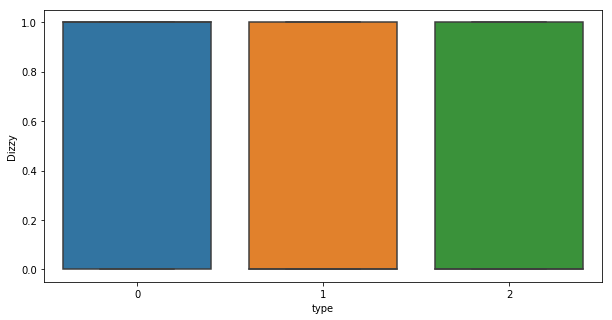

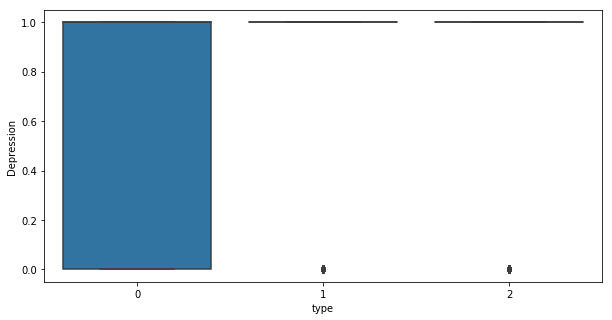

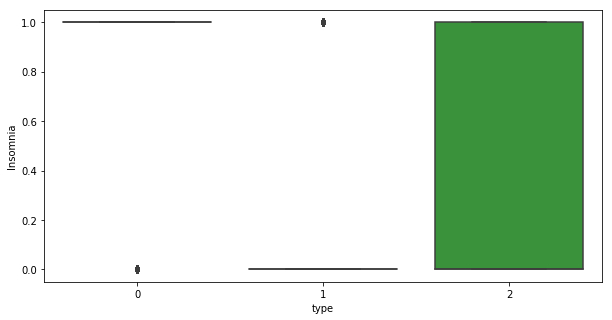

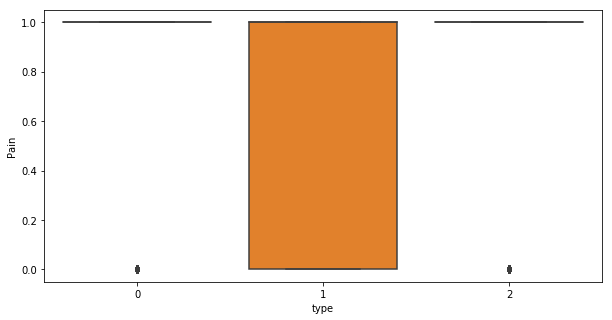

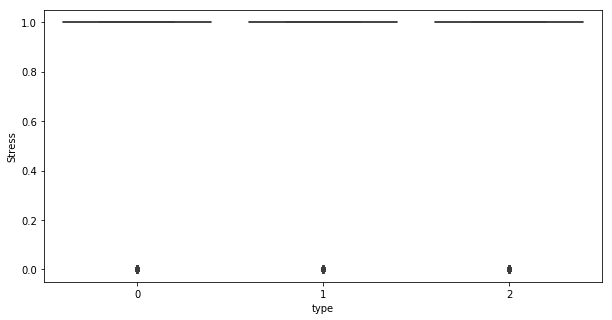

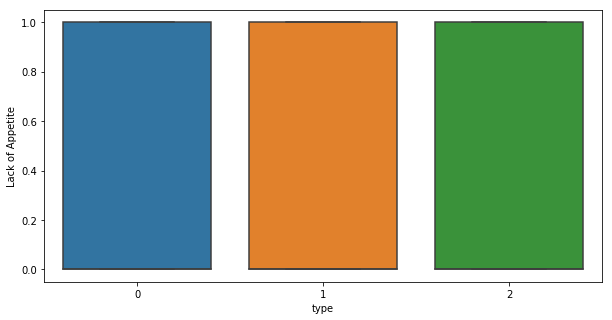

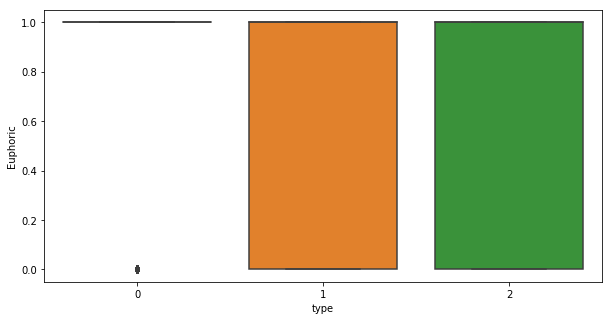

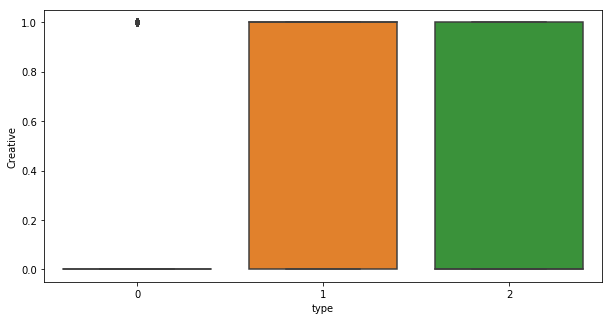

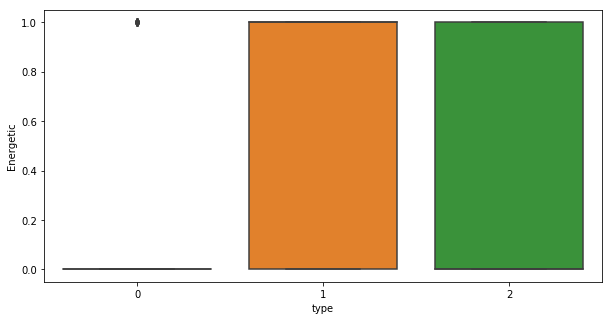

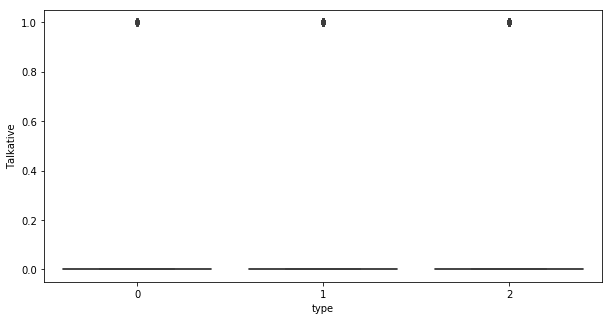

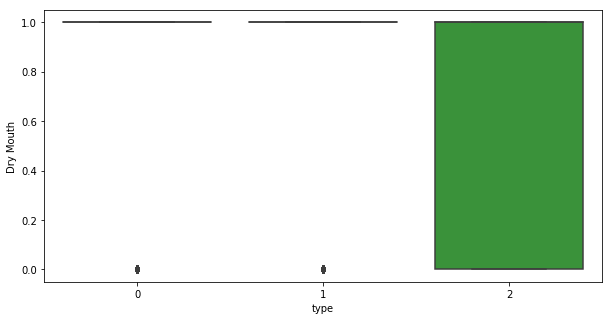

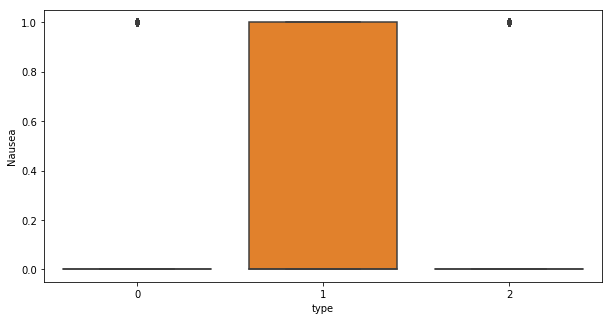

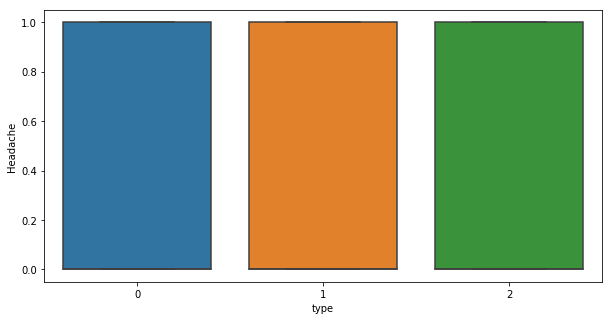

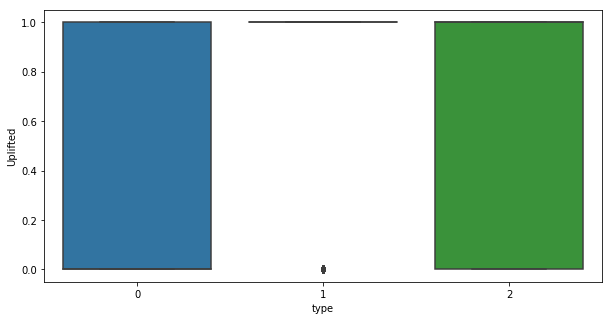

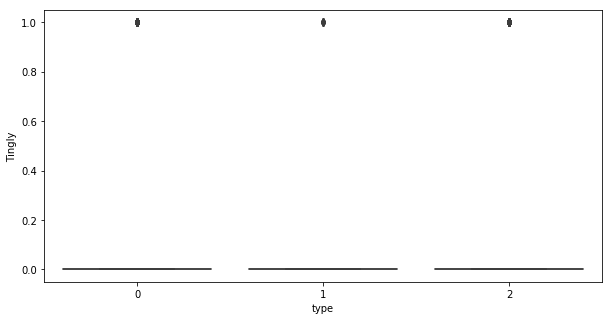

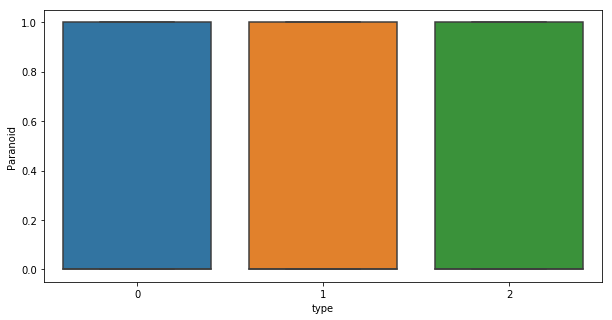

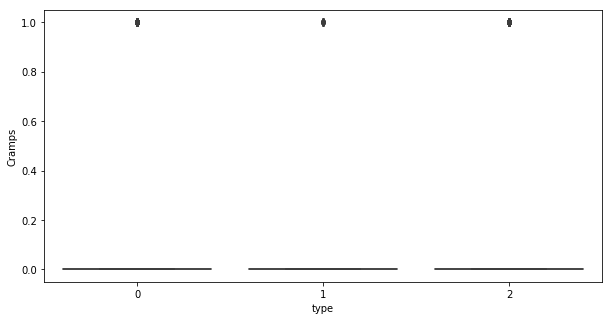

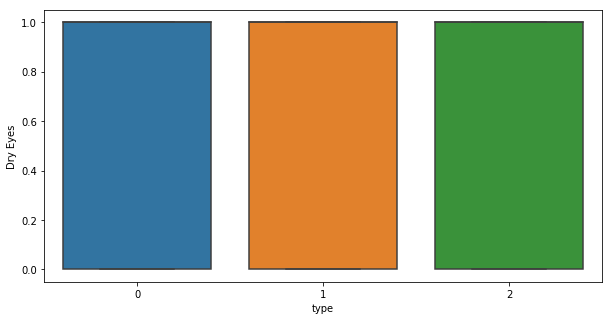

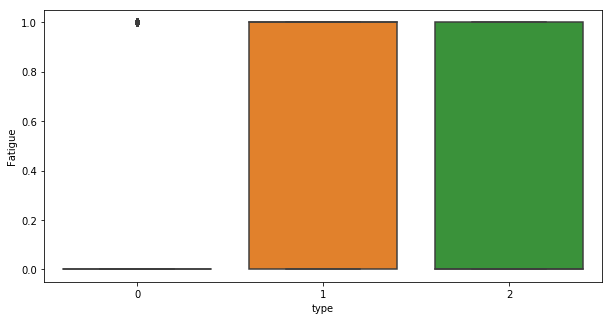

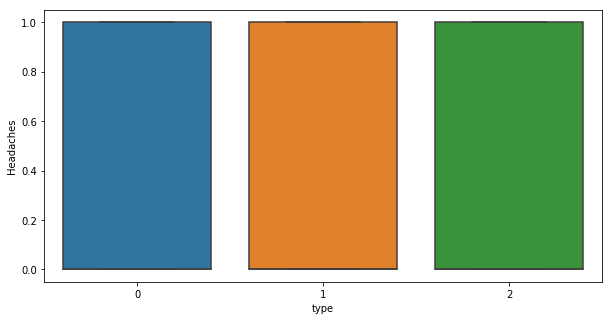

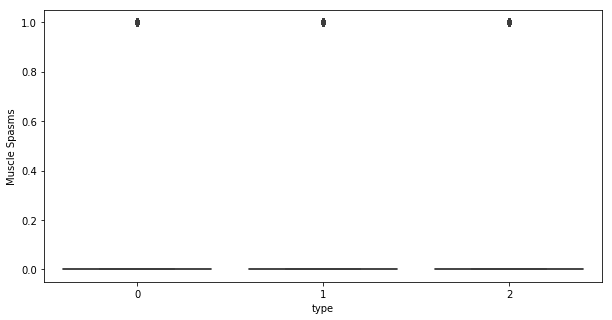

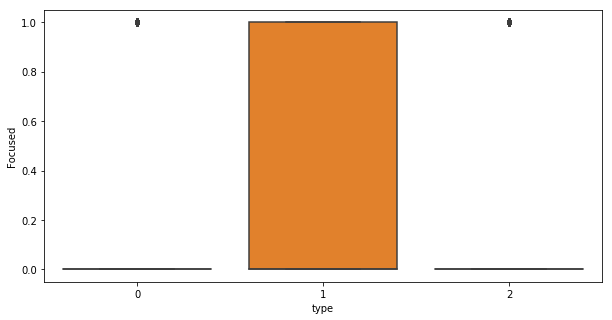

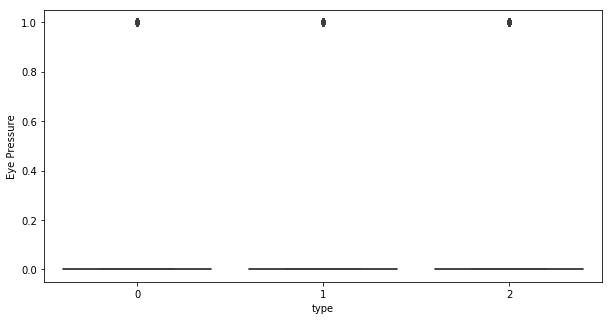

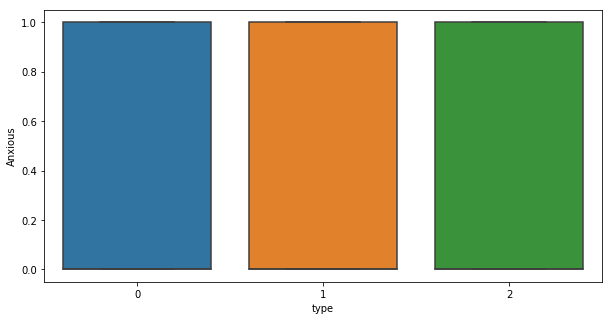

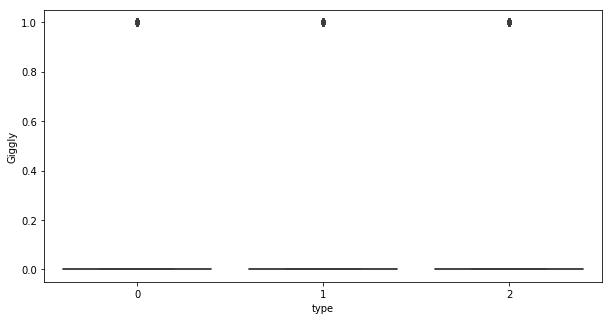

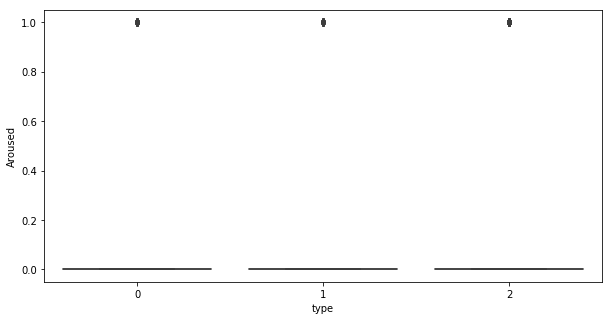

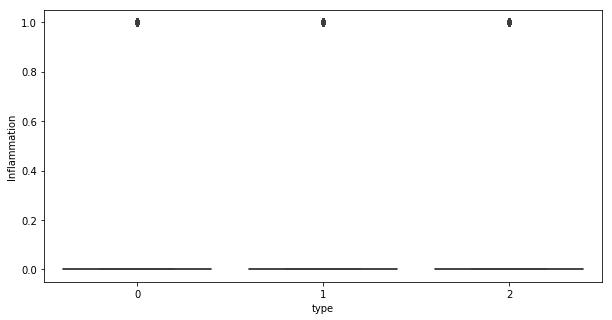

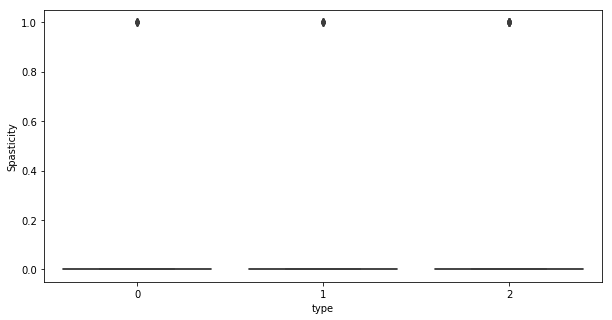

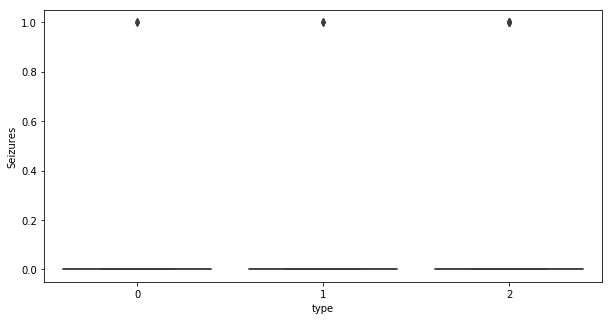

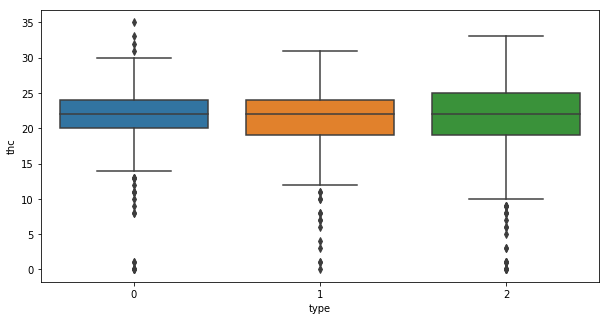

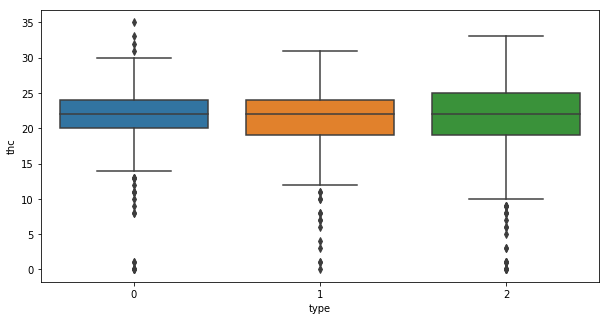

In [117]:
effects.append('thc')
for e in effects:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='type',y=e,data=fulldf)
# sns.scatterplot(sativadf['Relaxed'])
# sns.scatterplot(hybriddf['Relaxed'])

## Train Test Split

In [199]:
features=fulldf.drop(columns=['name','type'])
trainn=fulldf.drop(columns='name')
selectedfeatures=['thc','Relaxed','Hungry','Sleepy','Depression','Insomnia','Pain','Euphoric','Creative','Energetic','Dry Mouth','Nausea','Uplifted','Fatigue','Focused']
target=label_binarize(fulldf.type,classes=[0,1,2])
n_classes=target.shape[1]
                    
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)
trainx=X_train[selectedfeatures]
testx=X_test[selectedfeatures]

## Scale Features

In [119]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns=features.columns)

### Scale Selected Features:

In [120]:
scaled_data_trainsel = scaler.fit_transform(trainx)
df_test = scaler.transform(testx)

df_train = pd.DataFrame(scaled_data_trainsel, columns=trainx.columns)

## Scale all data

In [121]:
scaleddf= scaler.fit_transform(fulldf.drop(columns='name'))
scaleddf = pd.DataFrame(scaleddf, columns=fulldf.drop(columns='name').columns)

## Converting types

In [122]:
for i in fulldf['type']:
    i=float(i)
relax=[]
for i in fulldf['Relaxed']:
    relax.append(float(i))

## Looking at differences in effects among classes

In [123]:
# for i in range(0, 38, 5):
#     g = sns.PairGrid(fulldf,
#                      x_vars = effects[i:i+5],
#                      y_vars = ['type'])
#     g = g.map(sns.kdeplot)

In [124]:
# for i in range(0, 38, 5):
#     g = sns.PairGrid(scaleddf,
#                      x_vars = effects[i:i+5],
#                      y_vars = ['type'])
#     g = g.map(sns.kdeplot)

## Looking at distributions of each effect before and after scaling

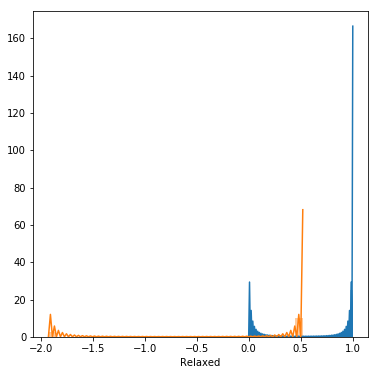

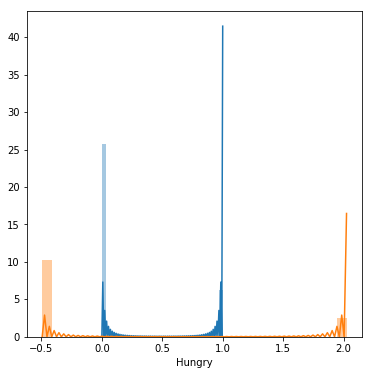

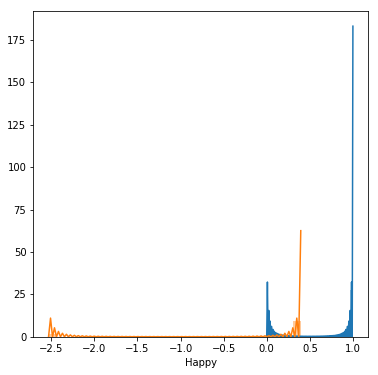

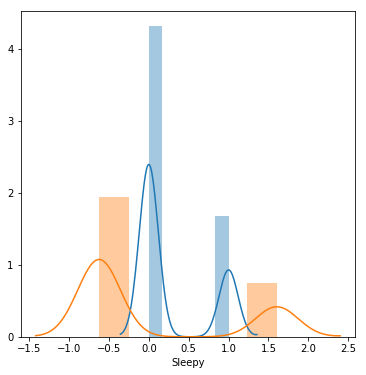

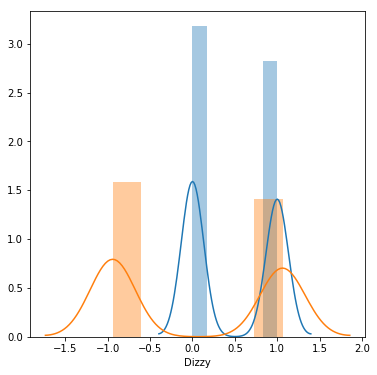

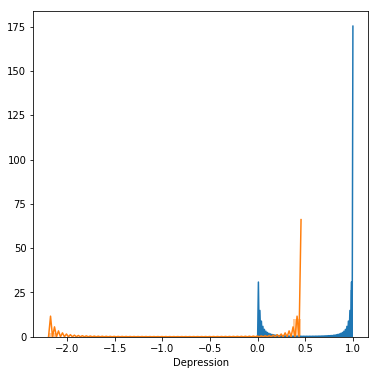

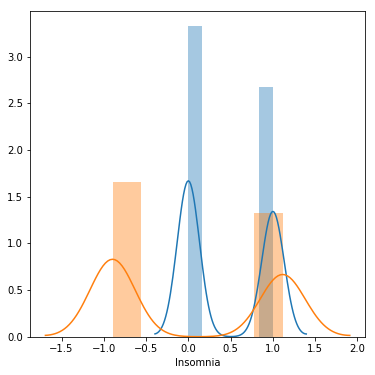

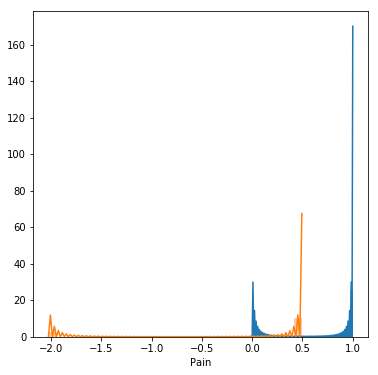

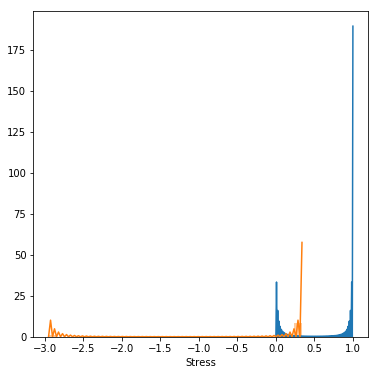

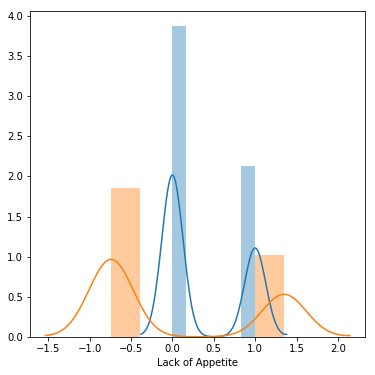

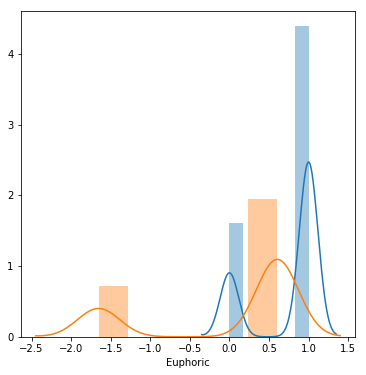

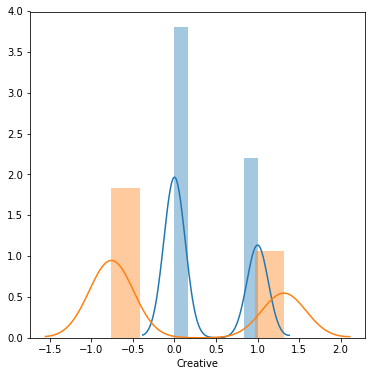

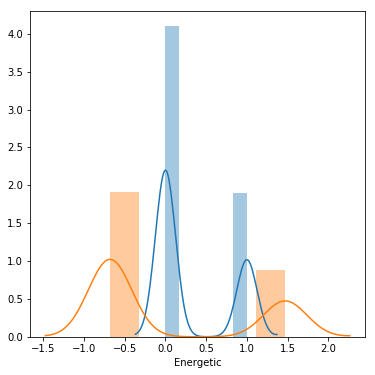

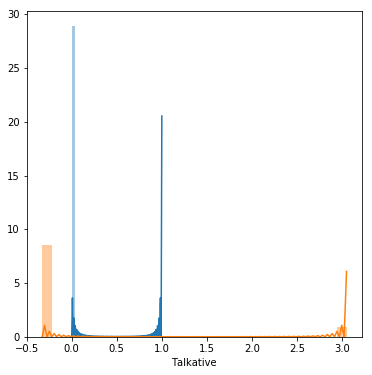

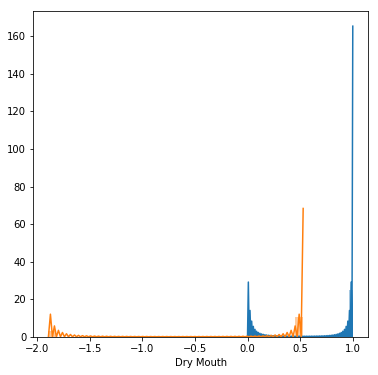

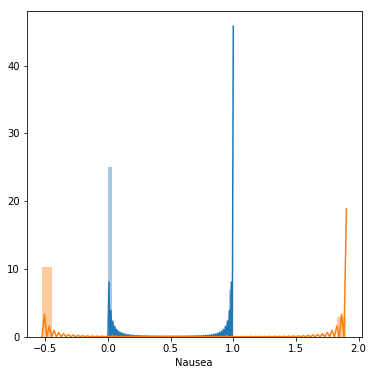

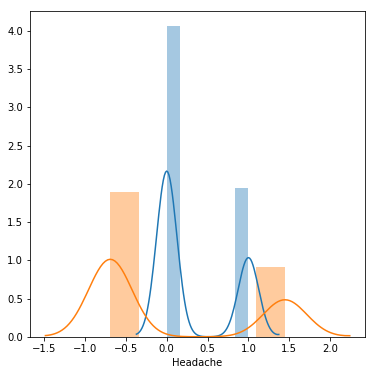

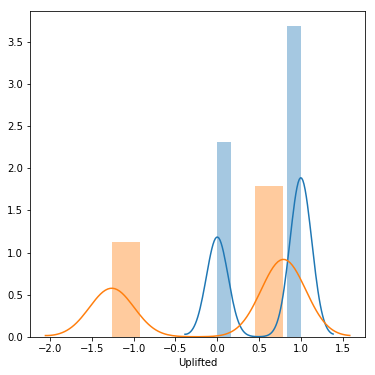

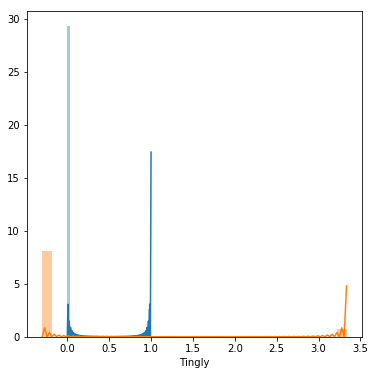

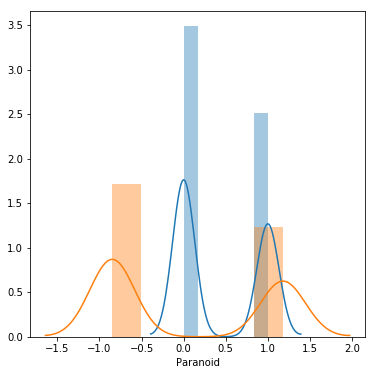

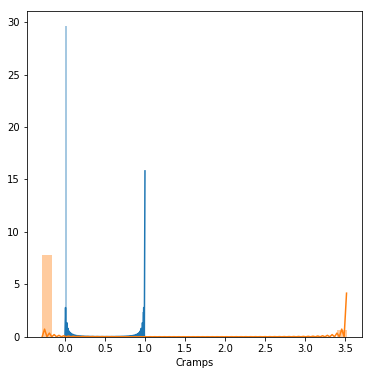

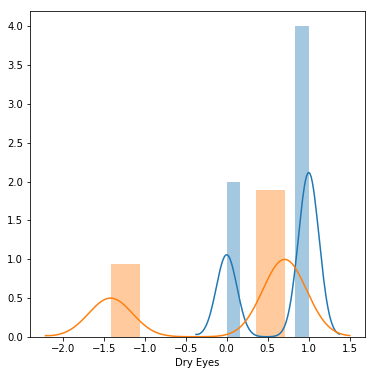

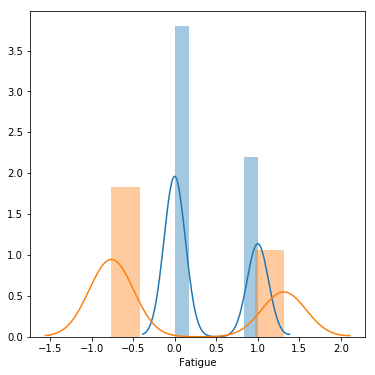

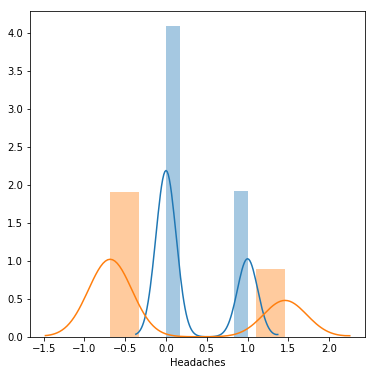

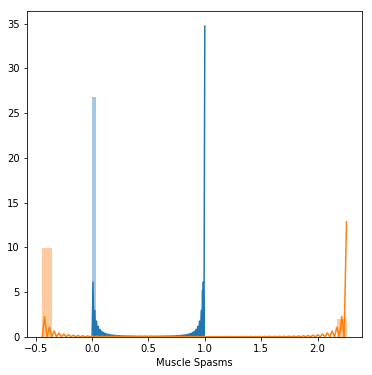

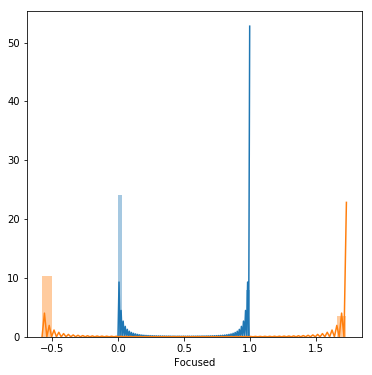

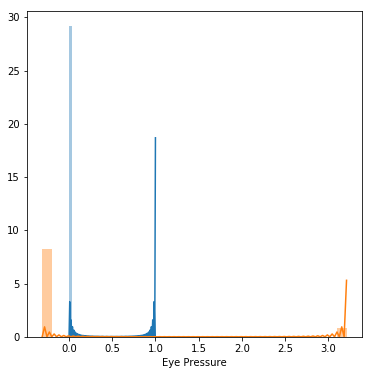

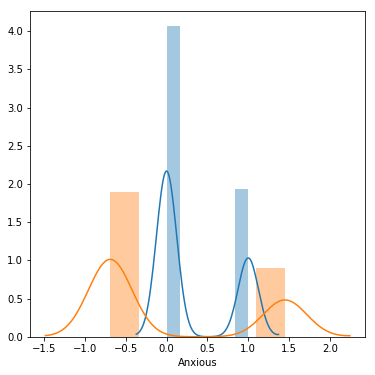

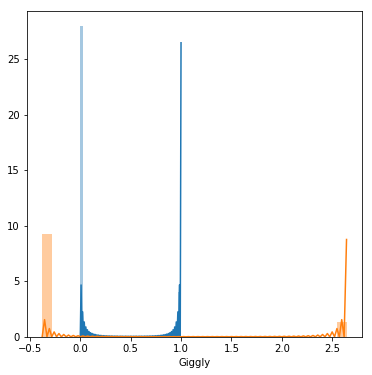

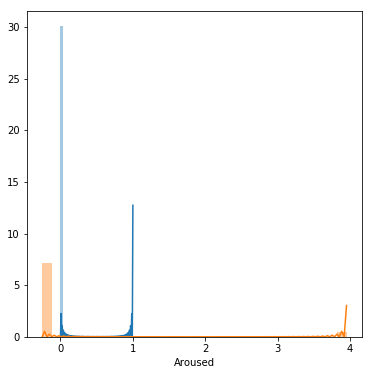

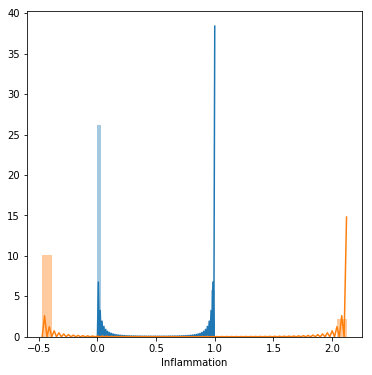

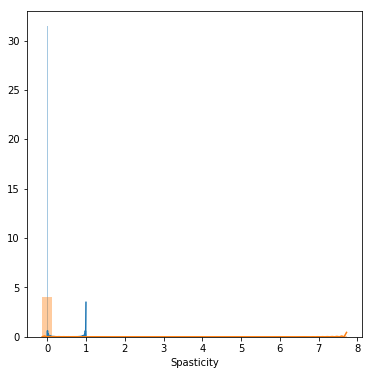

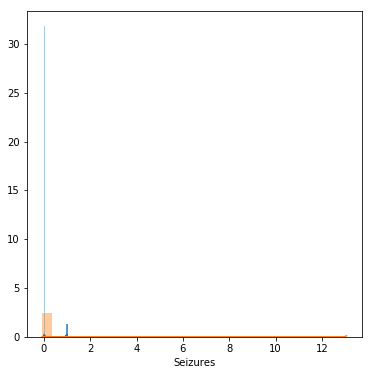

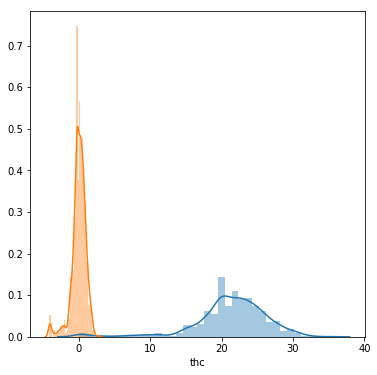

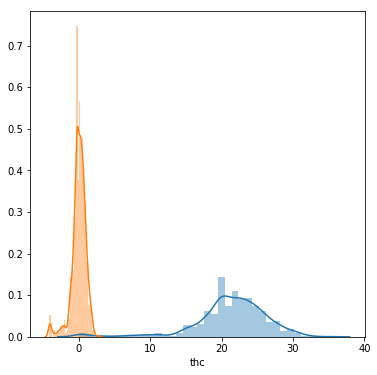

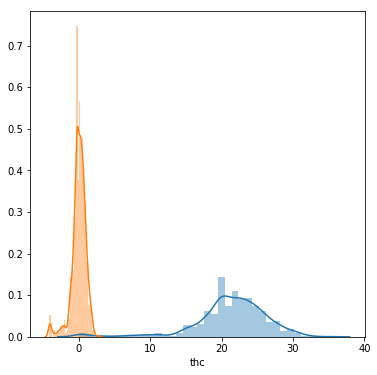

In [125]:
effects.append('thc')
for e in effects:
    plt.figure(figsize=(6,6))
    sns.distplot(X_train[e])
    sns.distplot(scaled_df_train[e])

## Examining different kinds of effects v. thc content

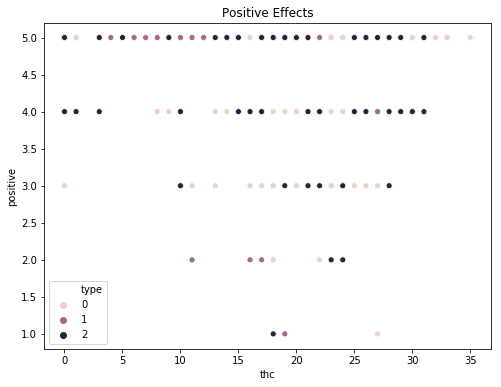

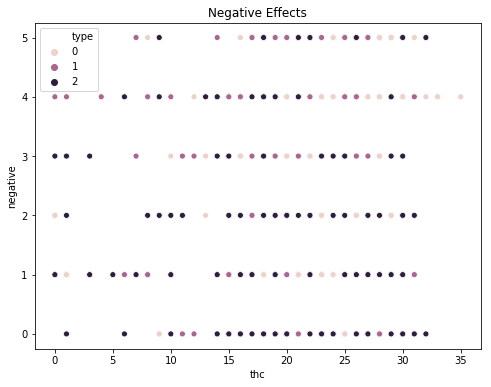

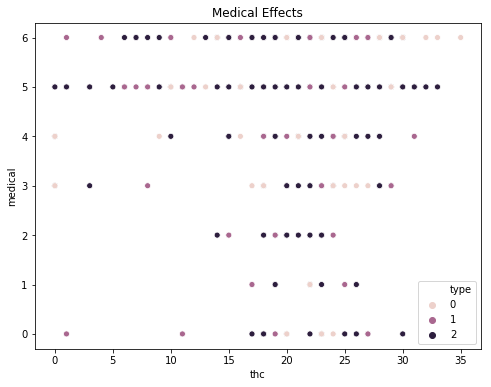

In [126]:
plt.figure(figsize=(8,6))
plt.title('Positive Effects')
sns.scatterplot(x='thc',y='positive',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Negative Effects')
sns.scatterplot(x='thc',y='negative',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Medical Effects')
sns.scatterplot(x='thc',y='medical',hue='type',data=fulldf)

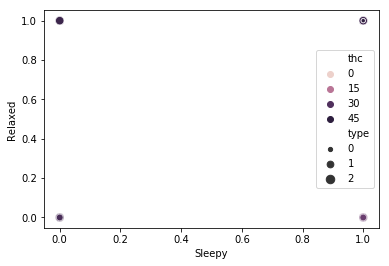

In [127]:
sns.scatterplot(x='Sleepy',y='Relaxed',hue='thc',alpha=0.8,size='type',data=fulldf)

# Beginning Modeling

## Baseline Model: Most probable to be hybrid, so predict all as hybrid

In [128]:
dummy = DummyClassifier(strategy='uniform', random_state=1)

from sklearn.metrics import precision_score

dummy.fit(scaled_data_train, y_train)
basepreds=dummy.predict(scaled_data_test)
sc=dummy.score(scaled_data_test, y_test) 
print("Baseline Model Metrics:")
print_metrics(y_test,basepreds)

Baseline Model Metrics:
Precision Score: [0.3220339  0.13605442 0.48837209]
Recall Score: [0.50892857 0.30769231 0.50299401]
Accuracy Score: 0.11918604651162791
F1 Score: [0.39446367 0.18867925 0.49557522]


### With Selected Features:

In [129]:
dummy = DummyClassifier(strategy='uniform', random_state=1)

dummy.fit(df_train, y_train)
basepreds=dummy.predict(df_test)
sc=dummy.score(df_test, y_test) 
print("Baseline Model Metrics:")
print_metrics(y_test,basepreds)

Baseline Model Metrics:
Precision Score: [0.3220339  0.13605442 0.48837209]
Recall Score: [0.50892857 0.30769231 0.50299401]
Accuracy Score: 0.11918604651162791
F1 Score: [0.39446367 0.18867925 0.49557522]


## KNN Base Model

In [130]:
clf1 = KNeighborsClassifier()
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)

Precision Score: [0.6627907  0.6        0.58378378]
Recall Score: [0.50892857 0.41538462 0.64670659]
Accuracy Score: 0.5581395348837209
F1 Score: [0.57575758 0.49090909 0.61363636]


### With Selected Features:

In [131]:
clf1 = KNeighborsClassifier()
clf1.fit(df_train, y_train)
test_preds = clf1.predict(df_test)
print_metrics(y_test, test_preds)

Precision Score: [0.64       0.62745098 0.57435897]
Recall Score: [0.42857143 0.49230769 0.67065868]
Accuracy Score: 0.5581395348837209
F1 Score: [0.51336898 0.55172414 0.61878453]


## Getting best KNN model

In [132]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 25
Accuracy: 0.5813953488372093


In [133]:
clf1 = KNeighborsClassifier(n_neighbors=25)
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)

Precision Score: [0.7260274  0.78571429 0.58962264]
Recall Score: [0.47321429 0.33846154 0.74850299]
Accuracy Score: 0.5813953488372093
F1 Score: [0.57297297 0.47311828 0.65963061]


### With Selected Features:

In [134]:
find_best_k(df_train, y_train, df_test, y_test)

Best Value for k: 13
Accuracy: 0.5872093023255814


In [135]:
clf1 = KNeighborsClassifier(n_neighbors=21)
clf1.fit(df_train, y_train)
test_preds = clf1.predict(df_test)
print_metrics(y_test, test_preds)

Precision Score: [0.70512821 0.62790698 0.58163265]
Recall Score: [0.49107143 0.41538462 0.68263473]
Accuracy Score: 0.5697674418604651
F1 Score: [0.57894737 0.5        0.62809917]


## Decision Tree

### Baseline Decision Tree

In [136]:
classifier1 = DecisionTreeClassifier()  
classifier1.fit(scaled_data_train, y_train) 
y_pred = classifier1.predict(scaled_data_test)

Accuracy:  0.4941860465116279
Micro-averaged precision score: 0.49
Macro-averaged precision score: 0.46
Per-class precision score: [0.42857143 0.33846154 0.5988024 ]
Precision Score: [0.5106383  0.39285714 0.51546392]
Recall Score: [0.42857143 0.33846154 0.5988024 ]
Accuracy Score: 0.4941860465116279
F1 Score: [0.46601942 0.36363636 0.55401662]


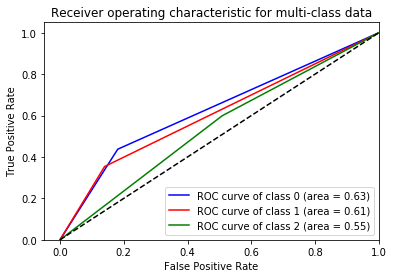

In [137]:
y_score = classifier1.score(scaled_data_test, y_test)
print('Accuracy: ', y_score)

# Compute the average precision score
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
roc(classifier1,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)

### With Selected Features:

In [138]:
classifier1 = DecisionTreeClassifier()  
classifier1.fit(df_train, y_train) 
y_pred = classifier1.predict(df_test)

Accuracy:  0.5261627906976745
Micro-averaged precision score: 0.53
Macro-averaged precision score: 0.52
Per-class precision score: [0.42857143 0.55384615 0.58083832]
Precision Score: [0.54545455 0.52941176 0.5739645 ]
Recall Score: [0.42857143 0.55384615 0.58083832]
Accuracy Score: 0.5261627906976745
F1 Score: [0.48       0.54135338 0.57738095]


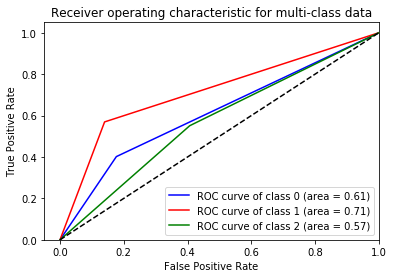

In [139]:
y_score = classifier1.score(df_test, y_test)
print('Accuracy: ', y_score)

# Compute the average precision score
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
roc(classifier1,df_train,df_test,y_train,y_test,n_classes)

## Decision Tree with random state=10

In [140]:
classifier2 = DecisionTreeClassifier(random_state=10)  
classifier2.fit(scaled_data_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [141]:
y_pred = classifier2.predict(scaled_data_test)

Accuracy:  0.4883720930232558
Micro-averaged precision score: 0.49
Macro-averaged precision score: 0.45
Per-class precision score: [0.41964286 0.33846154 0.59281437]
Precision Score: [0.50537634 0.37288136 0.515625  ]
Recall Score: [0.41964286 0.33846154 0.59281437]
Accuracy Score: 0.4883720930232558
F1 Score: [0.45853659 0.35483871 0.55153203]


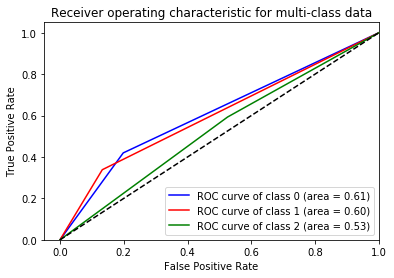

In [142]:
y_score = classifier2.score(scaled_data_test, y_test)
print('Accuracy: ', y_score)

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

print_metrics(y_test,y_pred)
roc(classifier2,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)

### With Selected Features:

In [143]:
classifier2 = DecisionTreeClassifier(random_state=10)  
classifier2.fit(df_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

Accuracy:  0.5290697674418605
Micro-averaged precision score: 0.53
Macro-averaged precision score: 0.53
Per-class precision score: [0.40178571 0.58461538 0.59281437]
Precision Score: [0.55555556 0.54285714 0.5625    ]
Recall Score: [0.40178571 0.58461538 0.59281437]
Accuracy Score: 0.5290697674418605
F1 Score: [0.46632124 0.56296296 0.57725948]


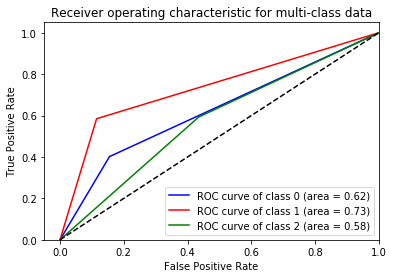

In [144]:
y_pred = classifier2.predict(df_test)
y_score = classifier2.score(df_test, y_test)
print('Accuracy: ', y_score)

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

print_metrics(y_test,y_pred)
roc(classifier2,df_train,df_test,y_train,y_test,n_classes)

## Decision Tree using entropy and random state=10

In [145]:
classifier3 = DecisionTreeClassifier(criterion='entropy',random_state=10)  
classifier3.fit(scaled_data_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

Accuracy is: 0.5087209302325582
Micro-averaged precision score: 0.51
Macro-averaged precision score: 0.48
Per-class precision score: [0.46428571 0.41538462 0.5748503 ]
Precision Score: [0.55913978 0.375      0.53631285]
Recall Score: [0.46428571 0.41538462 0.5748503 ]
Accuracy Score: 0.5087209302325582
F1 Score: [0.50731707 0.39416058 0.55491329]


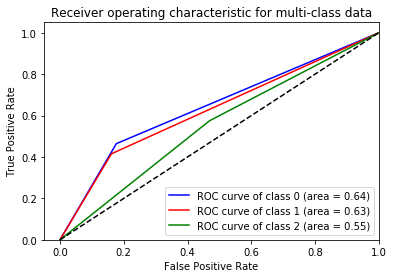

In [146]:
y_pred = classifier3.predict(scaled_data_test)

acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
roc(classifier3,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)

### With Selected Features:

In [147]:
classifier3 = DecisionTreeClassifier(criterion='entropy',random_state=10)  
classifier3.fit(df_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

Accuracy is: 0.5494186046511628
Micro-averaged precision score: 0.55
Macro-averaged precision score: 0.55
Per-class precision score: [0.48214286 0.6        0.5748503 ]
Precision Score: [0.60674157 0.51315789 0.59627329]
Recall Score: [0.48214286 0.6        0.5748503 ]
Accuracy Score: 0.5494186046511628
F1 Score: [0.53731343 0.55319149 0.58536585]


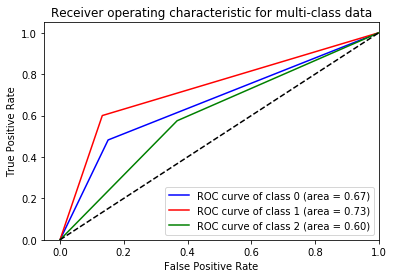

In [148]:
y_pred = classifier3.predict(df_test)

acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
roc(classifier3,df_train,df_test,y_train,y_test,n_classes)

In [149]:
#Still need to get F1, Recall, and Decision Tree visualization!!!

## Random Forest

### Regular Tree Baseline

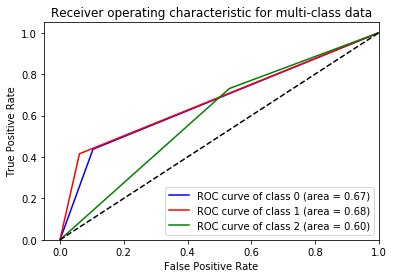

Precision Score: [0.48214286 0.6        0.5748503 ]
Recall Score: [0.60674157 0.51315789 0.59627329]
Accuracy Score: 0.5494186046511628
F1 Score: [0.53731343 0.55319149 0.58536585]


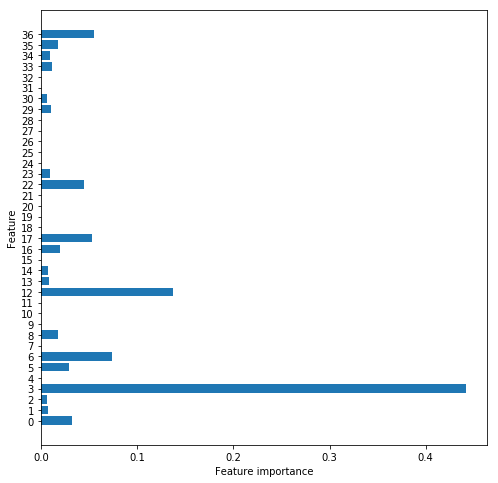

In [154]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(scaled_data_train, y_train)
roc(tree_clf,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)
plot_feature_importances(tree_clf, pd.DataFrame(scaled_data_train))
print_metrics(y_pred,y_test)

### With Selected Feautres:

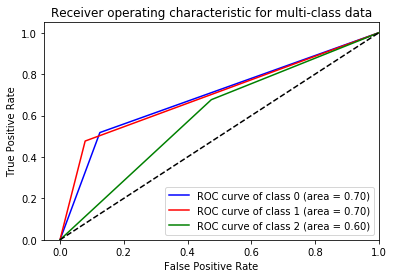

Precision Score: [0.48214286 0.6        0.5748503 ]
Recall Score: [0.60674157 0.51315789 0.59627329]
Accuracy Score: 0.5494186046511628
F1 Score: [0.53731343 0.55319149 0.58536585]


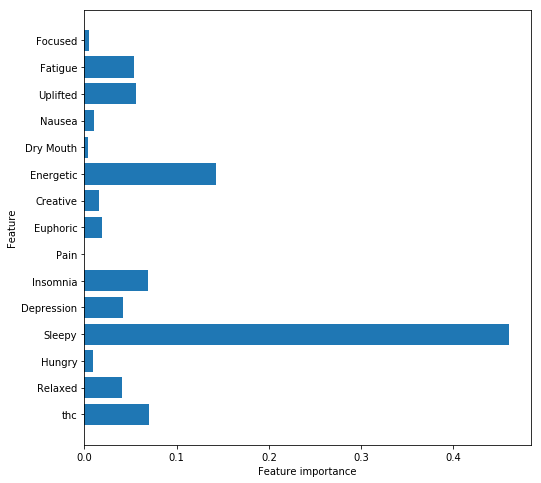

In [155]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(df_train, y_train)
roc(tree_clf,df_train,df_test,y_train,y_test,n_classes)
plot_feature_importances(tree_clf, df_train)
print_metrics(y_pred,y_test)

In [160]:
#How to with multilabel-indicator????
# pred = tree_clf.predict(X_test)
# print(confusion_matrix(y_test, pred))
# print(classification_report(X_test, pred))

# acc = accuracy_score(y_test,y_pred)
# print("Accuracy is: {}".format(acc))

### Forest

In [161]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(scaled_data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [162]:
train_score=forest.score(scaled_data_train,y_train)
test_score=forest.score(scaled_data_test,y_test)
print('Training Score: {}'.format(train_score))
print('Testing Score: {}'.format(test_score))

Training Score: 0.6621359223300971
Testing Score: 0.5813953488372093


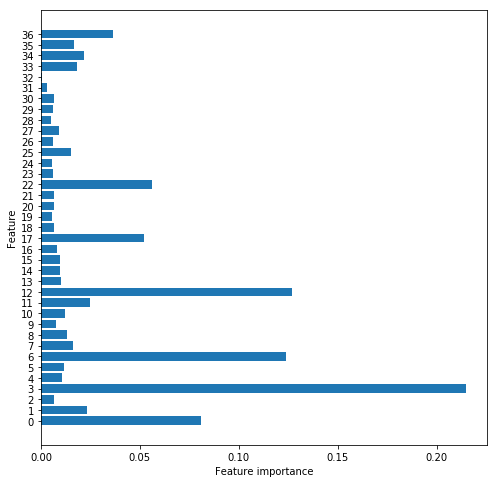

In [165]:
plot_feature_importances(forest,pd.DataFrame(scaled_data_train))

### For Selected Features:

In [166]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [167]:
train_score=forest.score(df_train,y_train)
test_score=forest.score(df_test,y_test)
print('Training Score: {}'.format(train_score))
print('Testing Score: {}'.format(test_score))

Training Score: 0.6699029126213593
Testing Score: 0.6046511627906976


## Forest with n_Est=5, max_feat=10, and max_depth=2

In [168]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(scaled_data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
print("Training Score: ",forest_2.score(scaled_data_train,y_train))
print("Testing Score: ",forest_2.score(scaled_data_test,y_test))

Training Score:  0.5223300970873787
Testing Score:  0.45930232558139533


### With Selected Features:

In [170]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [171]:
print("Training Score: ",forest_2.score(df_train,y_train))
print("Testing Score: ",forest_2.score(df_test,y_test))

Training Score:  0.5388349514563107
Testing Score:  0.502906976744186


## Grid Search

In [172]:
dt_clf=DecisionTreeClassifier()
dt_cv_score=cross_val_score(dt_clf, scaled_data_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

Mean Cross Validation Score: 56.89%


In [173]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [174]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(scaled_data_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [175]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(scaled_data_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 68.52%
Mean Testing Score: 60.17%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [176]:
forest3 = RandomForestClassifier(criterion='gini', max_depth=3,min_samples_leaf=5,min_samples_split=2)
forest3.fit(scaled_data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [177]:
y_pred=forest3.predict(scaled_data_test)
print_metrics(y_test,y_pred)

Precision Score: [0.7826087 0.        0.6      ]
Recall Score: [0.32142857 0.         0.79041916]
Accuracy Score: 0.4883720930232558
F1 Score: [0.4556962  0.         0.68217054]


In [178]:
print("Training Score: ",forest3.score(scaled_data_train,y_train))
print("Testing Score: ",forest3.score(scaled_data_test,y_test))

Training Score:  0.545631067961165
Testing Score:  0.4883720930232558


### With Selected Features:

In [179]:
dt_cv_score=cross_val_score(dt_clf, df_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

Mean Cross Validation Score: 52.91%


In [180]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(df_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [181]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(df_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 66.35%
Mean Testing Score: 60.76%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [182]:
forest3 = RandomForestClassifier(criterion='gini',max_depth=4,min_samples_leaf=4,min_samples_split=2)
forest3.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [183]:
y_pred=forest3.predict(df_test)
print_metrics(y_test,y_pred)
print("Training Score: ",forest3.score(df_train,y_train))
print("Testing Score: ",forest3.score(df_test,y_test))

Precision Score: [0.78947368 0.66666667 0.6       ]
Recall Score: [0.40178571 0.30769231 0.75449102]
Accuracy Score: 0.5552325581395349
F1 Score: [0.53254438 0.42105263 0.66843501]
Training Score:  0.6184466019417476
Testing Score:  0.5552325581395349


## XGBOOST

In [184]:
clf = xgb.XGBClassifier()
clf.fit(scaled_df_train, y_train)
training_preds = clf.predict(scaled_df_train)
val_preds = clf.predict(scaled_df_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

ValueError: bad input shape (1030, 3)

## SVM

In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(scaled_data_train, y_train)

## Naive Bayes

In [200]:
train=pd.concat([trainn,pd.DataFrame(y_train)],axis=1)
aggs=train.groupby('type').agg(['mean','std'])
def p_band_x_given_class(obs_row, feature, c, range_width_std):
    """obs_row is the observation in question.
    feature is the feature of the observation row for which you are calculating a conditional probability for.
    C is the class flag for the conditional probability.
    Range width is the range in standard deviations of the feature variable to calculate the integral under the PDF curve for"""
    mu = aggs[feature]['mean'][c]
    std = aggs[feature]['std'][c]

    obs = obs_row[feature] #observation
    interval_min = obs - range_width_std*std/2
    interval_max = obs + range_width_std*std/2
    
    cdf_min = stats.norm.cdf(interval_min, loc=mu, scale=std)
    cdf_max = stats.norm.cdf(interval_max, loc=mu, scale=std)
    p_x_given_y = cdf_max - cdf_min
    return p_x_given_y

In [201]:
def predict_class(obs_row, how='bands', range_width_std=.25):
    c_probs = []
    for c in range(2):
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in scaled_data_train.columns:
            if how == 'bands':
                p *= p_band_x_given_class(obs_row, feature, c, range_width_std=range_width_std)
            else:
                p *= p_x_given_class(obs_row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

In [202]:
scaled_data_train=pd.DataFrame(scaled_data_train)
scaled_data_test=pd.DataFrame(scaled_data_test)

In [203]:
train_accs = []
test_accs = []
range_stds = np.linspace(.1,2, num=21)
for range_std in range_stds:    
    y_hat_train = [predict_class(scaled_data_train.iloc[idx], range_width_std=range_std) for idx in range(len(scaled_data_train))]
    y_hat_test = [predict_class(scaled_data_test.iloc[idx], range_width_std=range_std) for idx in range(len(scaled_data_test))]
    
    residuals_train = y_hat_train == y_train
    acc_train = residuals_train.sum()/len(residuals_train)

    residuals_test = y_hat_test == y_test
    acc_test = residuals_test.sum()/len(residuals_test)
    
    train_accs.append(acc_train)
    test_accs.append(acc_test)
plt.plot(range_stds, train_accs, label='Train Accuracy')
plt.plot(range_stds, test_accs, label='Test Accuracy')
plt.title('Train and Test Accruaccy Versus Various Standard Deviation Bin Ranges for GNB')
plt.ylabel('Classifier Accuracy')
plt.xlabel('Standard Deviations Used for Integral Band Width')
plt.legend(loc=(1.01,.85));

KeyError: 3